In [53]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [54]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


/tmp/job.11870855/ipykernel_61111/3391910190.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [55]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("*.cali"))

(2/2) Creating Thicket: 100%|██████████| 279/279 [00:08<00:00, 34.35it/s]


In [56]:
# Convert the metadata columns 'input_size' and 'num_tasks' to performance data, forcing an overwrite
tk.metadata_column_to_perfdata("input_size", overwrite=True)
tk.metadata_column_to_perfdata("num_tasks", overwrite=True)
tk.metadata_column_to_perfdata("input_type", overwrite=True)


In [57]:
# Reset the index if 'input_size', 'num_tasks', or 'input_type' are part of it
if 'input_size' in tk.dataframe.index.names or 'num_tasks' in tk.dataframe.index.names or 'input_type' in tk.dataframe.index.names:
    tk.dataframe = tk.dataframe.reset_index()

# Convert the metadata columns 'input_size', 'num_tasks', and 'input_type' to performance data, forcing an overwrite
tk.metadata_column_to_perfdata("input_size", overwrite=True)
tk.metadata_column_to_perfdata("num_tasks", overwrite=True)
tk.metadata_column_to_perfdata("input_type", overwrite=True)

# Set the necessary index back for easier access (optional depending on your needs)
tk.dataframe = tk.dataframe.set_index(["input_size", "num_tasks", "input_type"]).sort_index()

# Confirm the changes by displaying the first few rows
print(tk.dataframe.head())


                                    nid   spot.channel  Min time/rank  \
input_size num_tasks input_type                                         
65536      2         1%_perturbed   1.0  regionprofile       0.411237   
                     1%_perturbed  16.0  regionprofile       0.000093   
                     1%_perturbed  13.0  regionprofile       0.000004   
                     1%_perturbed  15.0  regionprofile       0.000005   
                     1%_perturbed   2.0  regionprofile       0.000031   

                                   Max time/rank  Avg time/rank  Total time  \
input_size num_tasks input_type                                               
65536      2         1%_perturbed       0.411906       0.411572    0.823143   
                     1%_perturbed       0.000996       0.000545    0.001089   
                     1%_perturbed       0.000004       0.000004    0.000008   
                     1%_perturbed       0.000005       0.000005    0.000009   
              

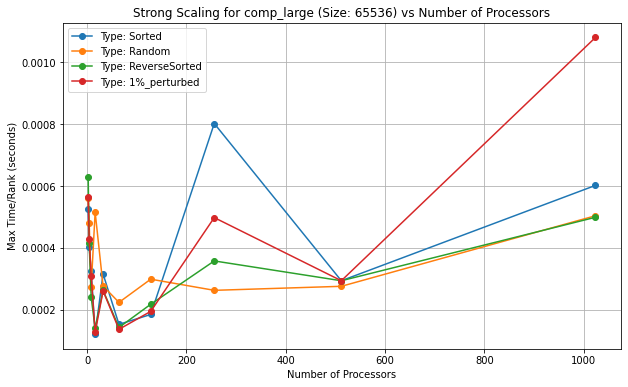

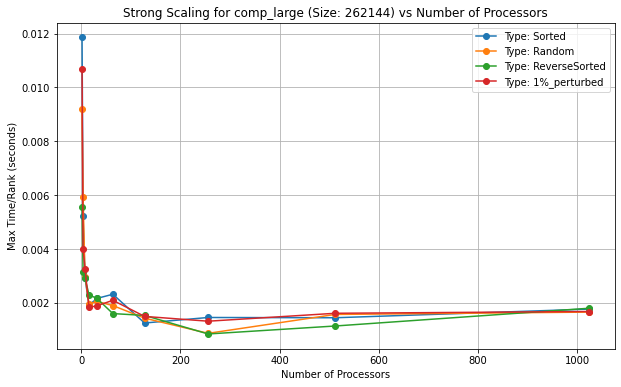

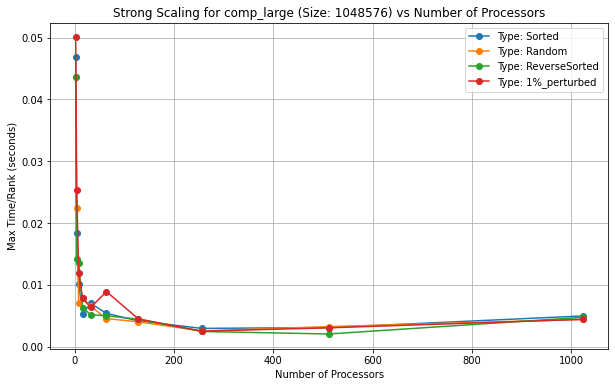

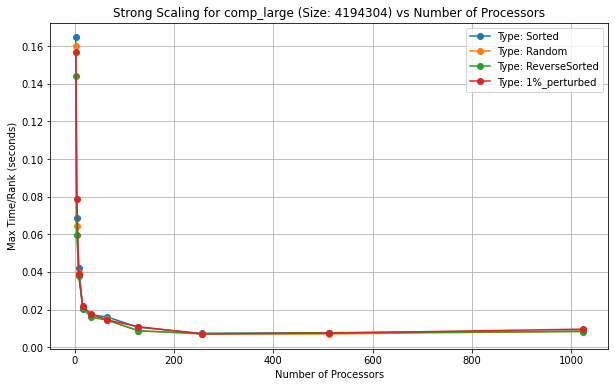

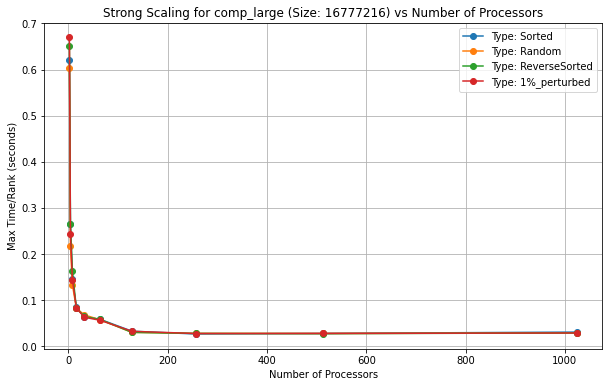

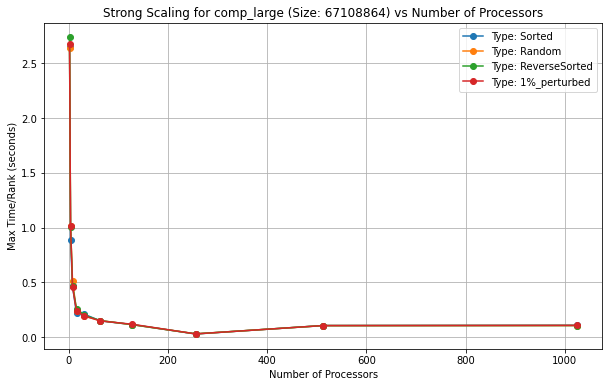

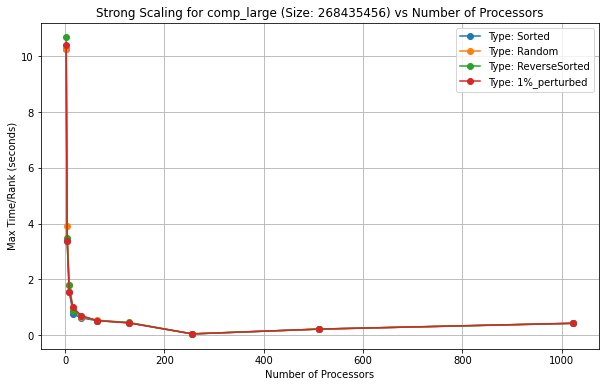

In [58]:
import matplotlib.pyplot as plt

# Define the strong scaling plot function
def plot_strong_scaling(df, phase, input_sizes, input_types):
    # Loop through each input size to create a separate graph
    for input_size in input_sizes:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input type to plot the data for the current input_size
        for input_type in input_types:
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_size') == input_size) &
                        (df.index.get_level_values('input_type') == input_type) &
                        (df['name'] == phase)]
            
            # Plot the Max time/rank for each num_tasks (or processors)
            plt.plot(subset.index.get_level_values('num_tasks'), subset['Max time/rank'], 
                     label=f"Type: {input_type}", marker = "o")
        
        plt.xlabel('Number of Processors')
        plt.ylabel('Max Time/Rank (seconds)')
        plt.title(f"Strong Scaling for {phase} (Size: {input_size}) vs Number of Processors")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        filename = f"./plots/strongscaling_{phase}_size_{input_size}.png"
        plt.savefig(filename)
        plt.close()  # Close the figure to free memory

# Example input sizes and types
input_sizes = tk.dataframe.index.get_level_values('input_size').unique()  # Get unique input sizes from the index
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']

# Call the function for comp_large phase, which will generate 7 graphs, one per input size
plot_strong_scaling(tk.dataframe, 'comp_large', input_sizes, input_types)



plot_strong_scaling(tk.dataframe, 'comm', input_sizes, input_types)

In [59]:
def plot_weak_scaling(df, phase, input_types, input_sizes):
    for input_type in input_types:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input size to plot the data for the current input type
        for input_size in input_sizes:
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_size') == input_size) &
                        (df.index.get_level_values('input_type') == input_type) &
                        (df['name'] == phase)]
            
            # Print communication times for each processor count
            print(f"Comm Times for {input_type} (Size: {input_size})")
            for num_tasks, comm_time in zip(subset.index.get_level_values('num_tasks'), subset['Avg time/rank']):
                print(f"Processors: {num_tasks}, Comm Time: {comm_time}")
            
            # Plot the Max time/rank for each num_tasks (or processors)
            plt.plot(subset.index.get_level_values('num_tasks'), subset['Avg time/rank'], 
                     label=f"Size: {input_size}", marker="o")
        
        plt.xlabel('Number of Processors')
        plt.ylabel('Max Time/Rank (seconds)')
        plt.title(f"Weak Scaling for {phase} ({input_type}) vs Number of Processors")
        plt.legend()
        plt.grid(True)
        plt.show()
        filename = f"./plots/weakscaling_{phase}_size_{input_size}.png"
        plt.savefig(filename)
        plt.close()  # Close the figure to free memory

# Define input types and sizes
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']
input_sizes = tk.dataframe.index.get_level_values('input_size').unique()

Comm Times for Sorted (Size: 65536)
Processors: 2, Comm Time: 0.047193
Processors: 4, Comm Time: 0.01207
Processors: 8, Comm Time: 0.00452
Processors: 16, Comm Time: 0.001824
Processors: 32, Comm Time: 0.001131
Processors: 64, Comm Time: 0.000695
Processors: 128, Comm Time: 0.000495
Processors: 256, Comm Time: 0.000441
Processors: 512, Comm Time: 0.000429
Processors: 1024, Comm Time: 0.000641
Comm Times for Sorted (Size: 262144)
Processors: 2, Comm Time: 0.196943
Processors: 4, Comm Time: 0.051158
Processors: 8, Comm Time: 0.017415
Processors: 16, Comm Time: 0.006675
Processors: 32, Comm Time: 0.003385
Processors: 64, Comm Time: 0.001799
Processors: 128, Comm Time: 0.000983
Processors: 256, Comm Time: 0.000708
Processors: 512, Comm Time: 0.000673
Processors: 1024, Comm Time: 0.000788
Comm Times for Sorted (Size: 1048576)
Processors: 2, Comm Time: 0.790314
Processors: 4, Comm Time: 0.199554
Processors: 8, Comm Time: 0.068479
Processors: 16, Comm Time: 0.02619
Processors: 32, Comm Time: 

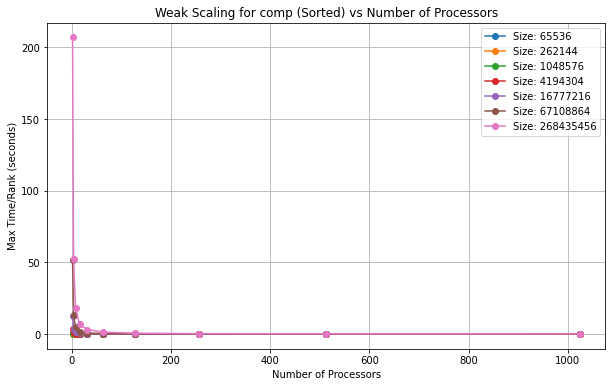

Comm Times for Random (Size: 65536)
Processors: 2, Comm Time: 0.047025
Processors: 4, Comm Time: 0.012205
Processors: 8, Comm Time: 0.004446
Processors: 16, Comm Time: 0.001963
Processors: 32, Comm Time: 0.001075
Processors: 64, Comm Time: 0.000712
Processors: 128, Comm Time: 0.000479
Processors: 256, Comm Time: 0.000402
Processors: 512, Comm Time: 0.000418
Processors: 1024, Comm Time: 0.000642
Comm Times for Random (Size: 262144)
Processors: 2, Comm Time: 0.194987
Processors: 4, Comm Time: 0.051319
Processors: 8, Comm Time: 0.017496
Processors: 16, Comm Time: 0.006758
Processors: 32, Comm Time: 0.003233
Processors: 64, Comm Time: 0.001778
Processors: 128, Comm Time: 0.001077
Processors: 256, Comm Time: 0.000828
Processors: 512, Comm Time: 0.000653
Processors: 1024, Comm Time: 0.000826
Comm Times for Random (Size: 1048576)
Processors: 2, Comm Time: 0.793947
Processors: 4, Comm Time: 0.211405
Processors: 8, Comm Time: 0.069087
Processors: 16, Comm Time: 0.026073
Processors: 32, Comm Tim

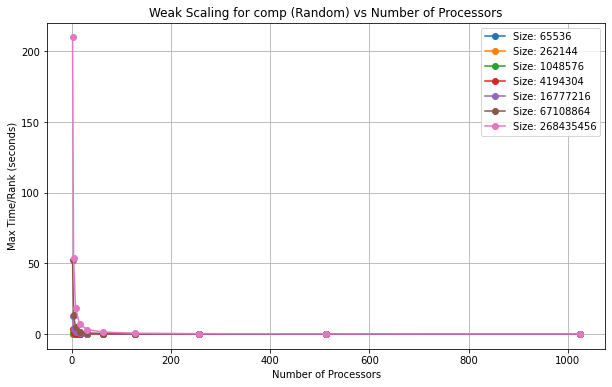

Comm Times for ReverseSorted (Size: 65536)
Processors: 2, Comm Time: 0.047909
Processors: 4, Comm Time: 0.01326
Processors: 8, Comm Time: 0.004389
Processors: 16, Comm Time: 0.001862
Processors: 32, Comm Time: 0.001035
Processors: 64, Comm Time: 0.000636
Processors: 128, Comm Time: 0.000492
Processors: 256, Comm Time: 0.000411
Processors: 512, Comm Time: 0.000422
Processors: 1024, Comm Time: 0.000638
Comm Times for ReverseSorted (Size: 262144)
Processors: 2, Comm Time: 0.189396
Processors: 4, Comm Time: 0.050063
Processors: 8, Comm Time: 0.017138
Processors: 16, Comm Time: 0.006644
Processors: 32, Comm Time: 0.003323
Processors: 64, Comm Time: 0.001785
Processors: 128, Comm Time: 0.000985
Processors: 256, Comm Time: 0.000789
Processors: 512, Comm Time: 0.000677
Processors: 1024, Comm Time: 0.000829
Comm Times for ReverseSorted (Size: 1048576)
Processors: 2, Comm Time: 0.786845
Processors: 4, Comm Time: 0.196795
Processors: 8, Comm Time: 0.073422
Processors: 16, Comm Time: 0.026196
Proc

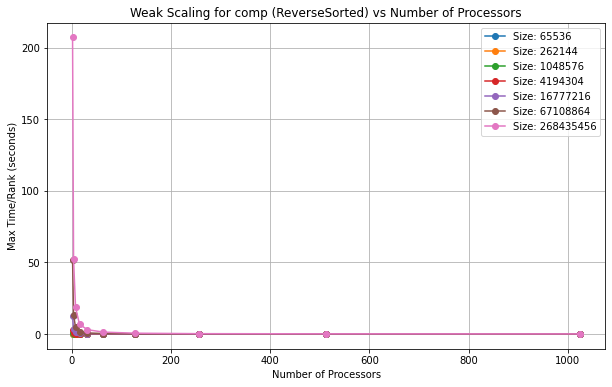

Comm Times for 1%_perturbed (Size: 65536)
Processors: 2, Comm Time: 0.046952
Processors: 4, Comm Time: 0.012587
Processors: 8, Comm Time: 0.00443
Processors: 16, Comm Time: 0.001871
Processors: 32, Comm Time: 0.001083
Processors: 64, Comm Time: 0.000643
Processors: 128, Comm Time: 0.000499
Processors: 256, Comm Time: 0.00044
Processors: 512, Comm Time: 0.000421
Processors: 1024, Comm Time: 0.00064
Comm Times for 1%_perturbed (Size: 262144)
Processors: 2, Comm Time: 0.196114
Processors: 4, Comm Time: 0.050418
Processors: 8, Comm Time: 0.017654
Processors: 16, Comm Time: 0.00653
Processors: 32, Comm Time: 0.003161
Processors: 64, Comm Time: 0.001748
Processors: 128, Comm Time: 0.000997
Processors: 256, Comm Time: 0.000798
Processors: 512, Comm Time: 0.000674
Processors: 1024, Comm Time: 0.000848
Comm Times for 1%_perturbed (Size: 1048576)
Processors: 2, Comm Time: 0.796114
Processors: 4, Comm Time: 0.210449
Processors: 8, Comm Time: 0.070083
Processors: 16, Comm Time: 0.026067
Processors

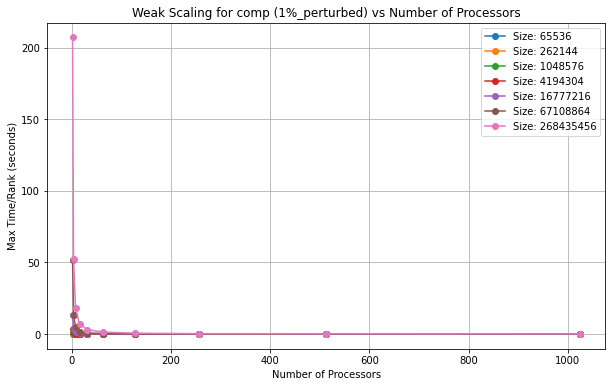

In [60]:
plot_weak_scaling(tk.dataframe, 'comp', input_types, input_sizes)

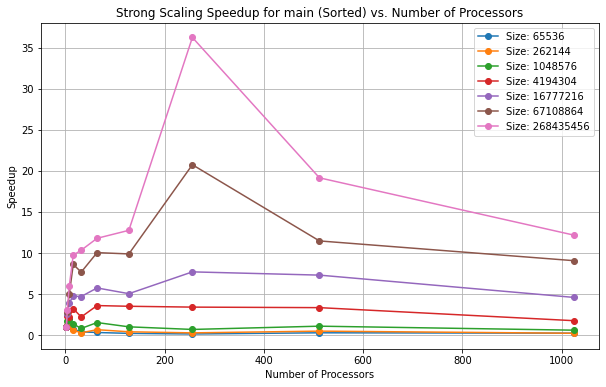

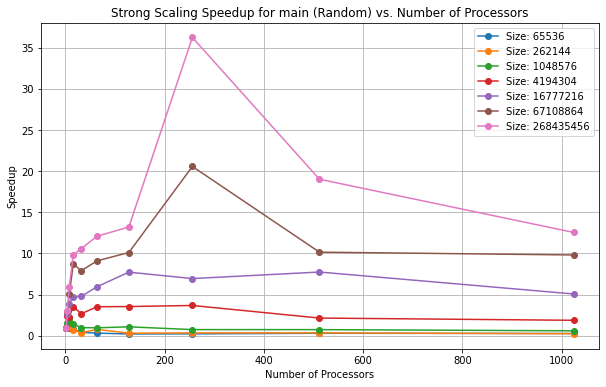

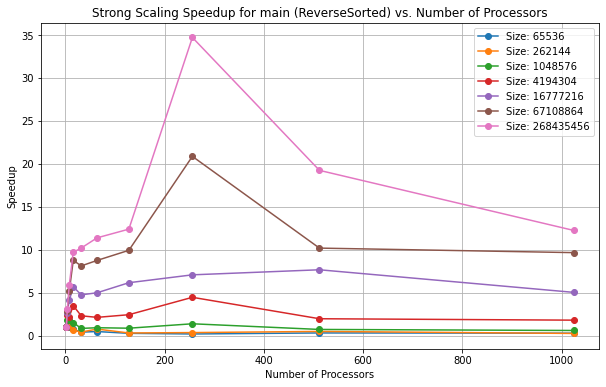

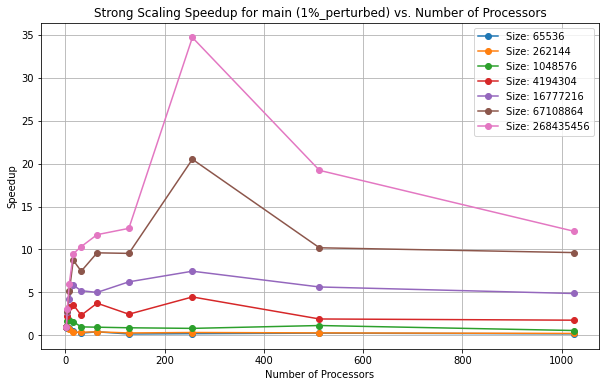

In [61]:
def plot_strong_scaling_speedup(df, phase, input_types):
    # Loop through each input type to create a separate graph
    for input_type in input_types:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input size and calculate speedup
        for input_size in df.index.get_level_values('input_size').unique():
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_type') == input_type) &
                        (df.index.get_level_values('input_size') == input_size) &
                        (df['name'] == phase)]
            
            # Calculate the speedup based on the Max time for 2 processors (num_tasks == 2)
            base_time = subset[subset.index.get_level_values('num_tasks') == 2]['Avg time/rank'].values[0]
            speedup = base_time / subset['Avg time/rank']
            
            # Plot the speedup for each input_size
            plt.plot(subset.index.get_level_values('num_tasks'), speedup, 
                     label=f"Size: {input_size}", marker = "o")
        
        plt.xlabel('Number of Processors')
        plt.ylabel('Speedup')
        plt.title(f"Strong Scaling Speedup for {phase} ({input_type}) vs. Number of Processors")
        plt.legend()
        plt.grid(True)
        plt.show()
        

# Define input types
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']
plot_strong_scaling_speedup(tk.dataframe, 'main', input_types)

Speedup and Total Time for Sorted, Size: 65536
Processors: 2, Speedup: 1.0, Total Time: 1.32528
Processors: 4, Speedup: 1.1264770731723903, Total Time: 2.352964
Processors: 8, Speedup: 1.2020156945547948, Total Time: 4.410188
Processors: 16, Speedup: 0.746117910140218, Total Time: 14.209868
Processors: 32, Speedup: 0.4100477287536502, Total Time: 51.712217
Processors: 64, Speedup: 0.328177861069193, Total Time: 129.225544
Processors: 128, Speedup: 0.2211281057346343, Total Time: 383.569143
Processors: 256, Speedup: 0.14799564660880163, Total Time: 1146.221732
Processors: 512, Speedup: 0.2906260978411372, Total Time: 1167.382243
Processors: 1024, Speedup: 0.24437421885919608, Total Time: 2776.657126
Speedup and Total Time for Sorted, Size: 262144
Processors: 2, Speedup: 1.0, Total Time: 1.223817
Processors: 4, Speedup: 1.2356231435131244, Total Time: 1.980893
Processors: 8, Speedup: 1.102308346363643, Total Time: 4.440931
Processors: 16, Speedup: 0.6046143281310984, Total Time: 16.19303

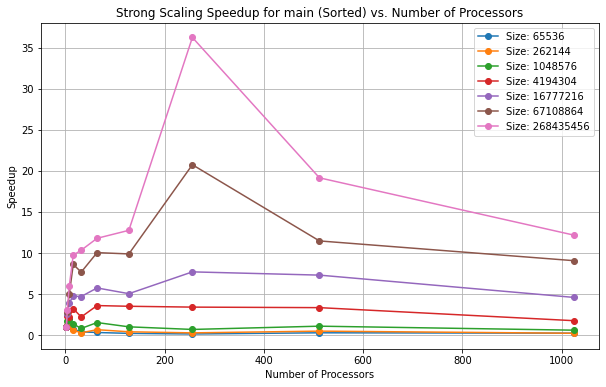

Speedup and Total Time for Random, Size: 65536
Processors: 2, Speedup: 1.0, Total Time: 1.329406
Processors: 4, Speedup: 1.120566096580325, Total Time: 2.372741
Processors: 8, Speedup: 0.965795560876666, Total Time: 5.505953
Processors: 16, Speedup: 0.8544827683728393, Total Time: 12.446411
Processors: 32, Speedup: 0.4123201728920715, Total Time: 51.587322
Processors: 64, Speedup: 0.3213828635581908, Total Time: 132.368598
Processors: 128, Speedup: 0.2172106384696049, Total Time: 391.702651
Processors: 256, Speedup: 0.23123659359108428, Total Time: 735.886975
Processors: 512, Speedup: 0.3021805819734435, Total Time: 1126.240041
Processors: 1024, Speedup: 0.27501329135265634, Total Time: 2474.993063
Speedup and Total Time for Random, Size: 262144
Processors: 2, Speedup: 1.0, Total Time: 1.33536
Processors: 4, Speedup: 1.1263157894736844, Total Time: 2.371202
Processors: 8, Speedup: 1.2082628326351128, Total Time: 4.420758
Processors: 16, Speedup: 0.7033126311442947, Total Time: 15.18937

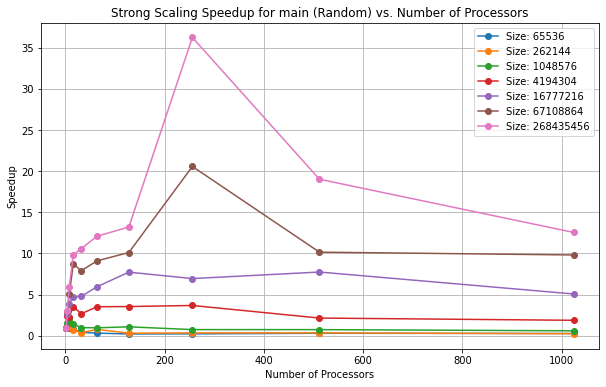

Speedup and Total Time for ReverseSorted, Size: 65536
Processors: 2, Speedup: 1.0, Total Time: 1.326823
Processors: 4, Speedup: 1.1190990690087363, Total Time: 2.371238
Processors: 8, Speedup: 0.9875847038788124, Total Time: 5.374015
Processors: 16, Speedup: 0.7397555082019494, Total Time: 14.348789
Processors: 32, Speedup: 0.39618654948897997, Total Time: 53.583818
Processors: 64, Speedup: 0.4633156851940702, Total Time: 91.640282
Processors: 128, Speedup: 0.2544839811100656, Total Time: 333.682101
Processors: 256, Speedup: 0.17982309673949812, Total Time: 944.447453
Processors: 512, Speedup: 0.30028969238290093, Total Time: 1131.130976
Processors: 1024, Speedup: 0.2717490548964943, Total Time: 2499.857214
Speedup and Total Time for ReverseSorted, Size: 262144
Processors: 2, Speedup: 1.0, Total Time: 1.301293
Processors: 4, Speedup: 1.0244812226125375, Total Time: 2.540396
Processors: 8, Speedup: 1.1692295251359, Total Time: 4.451796
Processors: 16, Speedup: 0.6307781199981775, Total 

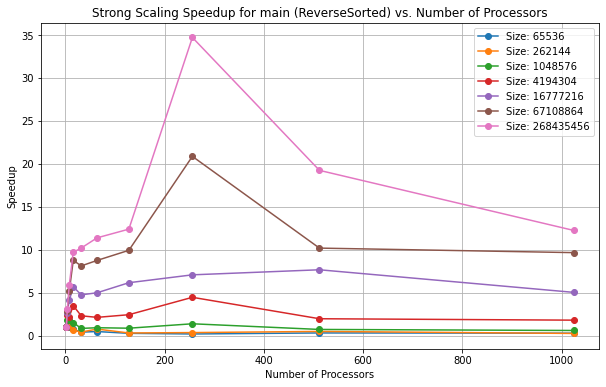

Speedup and Total Time for 1%_perturbed, Size: 65536
Processors: 2, Speedup: 1.0, Total Time: 0.823143
Processors: 4, Speedup: 0.8726808561166028, Total Time: 1.886471
Processors: 8, Speedup: 0.8253013376967393, Total Time: 3.98954
Processors: 16, Speedup: 0.4721389256617392, Total Time: 13.947493
Processors: 32, Speedup: 0.2577563898623953, Total Time: 51.095925
Processors: 64, Speedup: 0.40960915293911576, Total Time: 64.306692
Processors: 128, Speedup: 0.15858438777676612, Total Time: 332.196725
Processors: 256, Speedup: 0.19707555603651986, Total Time: 534.629674
Processors: 512, Speedup: 0.25600081607366554, Total Time: 823.141579
Processors: 1024, Speedup: 0.1753400426621633, Total Time: 2403.613846
Speedup and Total Time for 1%_perturbed, Size: 262144
Processors: 2, Speedup: 1.0, Total Time: 1.203227
Processors: 4, Speedup: 0.9344791432055234, Total Time: 2.575181
Processors: 8, Speedup: 0.6867148208941253, Total Time: 7.008591
Processors: 16, Speedup: 0.3405631624591571, Total 

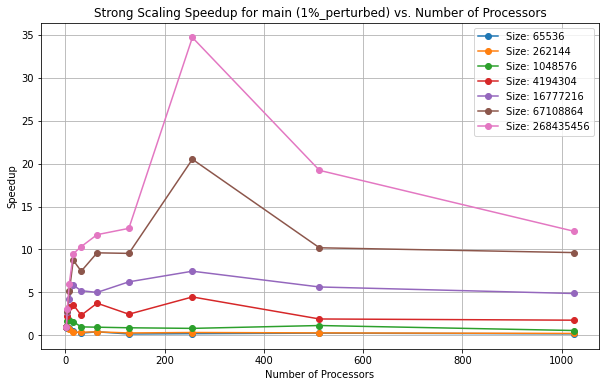

In [62]:
def plot_strong_scaling_speedup_time(df, phase, input_types):
    # Loop through each input type to create a separate graph
    for input_type in input_types:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input size and calculate speedup
        for input_size in df.index.get_level_values('input_size').unique():
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_type') == input_type) &
                        (df.index.get_level_values('input_size') == input_size) &
                        (df['name'] == phase)]
            
            # Calculate the speedup based on the Max time for 2 processors (num_tasks == 2)
            base_time = subset[subset.index.get_level_values('num_tasks') == 2]['Avg time/rank'].values[0]
            speedup = base_time / subset['Avg time/rank']
            
            # Print out speedup values and total time for each processor count
            print(f"Speedup and Total Time for {input_type}, Size: {input_size}")
            for num_tasks, speedup_value, total_time in zip(subset.index.get_level_values('num_tasks'), 
                                                            speedup, 
                                                            subset['Total time']):
                print(f"Processors: {num_tasks}, Speedup: {speedup_value}, Total Time: {total_time}")
            
            # Plot the speedup for each input_size
            plt.plot(subset.index.get_level_values('num_tasks'), speedup, 
                     label=f"Size: {input_size}", marker="o")
        
        plt.xlabel('Number of Processors')
        plt.ylabel('Speedup')
        plt.title(f"Strong Scaling Speedup for {phase} ({input_type}) vs. Number of Processors")
        plt.legend()
        plt.grid(True)
        plt.show()

# Define input types
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']
plot_strong_scaling_speedup_time(tk.dataframe, 'main', input_types)


Weak Scaling Speedup for Sorted (Size: 65536)
Processors: 2, Speedup: 1.0
Processors: 4, Speedup: 3.9099420049710023
Processors: 8, Speedup: 10.440929203539824
Processors: 16, Speedup: 25.873355263157894
Processors: 32, Speedup: 41.72679045092838
Processors: 64, Speedup: 67.90359712230216
Processors: 128, Speedup: 95.33939393939394
Processors: 256, Speedup: 107.01360544217687
Processors: 512, Speedup: 110.006993006993
Processors: 1024, Speedup: 73.62402496099844
Weak Scaling Speedup for Sorted (Size: 262144)
Processors: 2, Speedup: 1.0
Processors: 4, Speedup: 3.8497009265413036
Processors: 8, Speedup: 11.308814240597187
Processors: 16, Speedup: 29.50456928838951
Processors: 32, Speedup: 58.18109305760709
Processors: 64, Speedup: 109.47359644246804
Processors: 128, Speedup: 200.34893184130215
Processors: 256, Speedup: 278.16807909604523
Processors: 512, Speedup: 292.63447251114417
Processors: 1024, Speedup: 249.92766497461932
Weak Scaling Speedup for Sorted (Size: 1048576)
Processors: 2

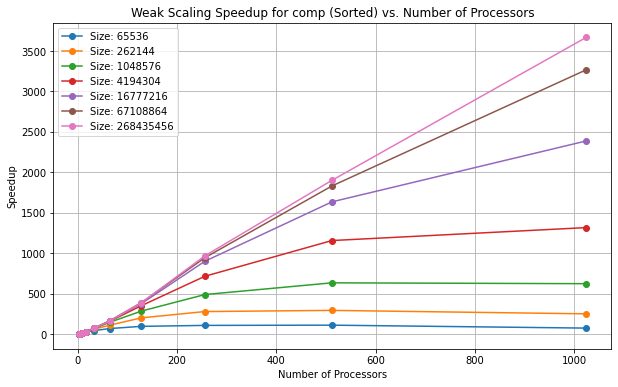

Weak Scaling Speedup for Random (Size: 65536)
Processors: 2, Speedup: 1.0
Processors: 4, Speedup: 3.8529291274068003
Processors: 8, Speedup: 10.576923076923075
Processors: 16, Speedup: 23.955680081507897
Processors: 32, Speedup: 43.74418604651162
Processors: 64, Speedup: 66.04634831460675
Processors: 128, Speedup: 98.17327766179541
Processors: 256, Speedup: 116.9776119402985
Processors: 512, Speedup: 112.49999999999999
Processors: 1024, Speedup: 73.24766355140187
Weak Scaling Speedup for Random (Size: 262144)
Processors: 2, Speedup: 1.0
Processors: 4, Speedup: 3.7995089537987883
Processors: 8, Speedup: 11.144661636945587
Processors: 16, Speedup: 28.85276709085528
Processors: 32, Speedup: 60.31147540983606
Processors: 64, Speedup: 109.66647919010123
Processors: 128, Speedup: 181.0464252553389
Processors: 256, Speedup: 235.4915458937198
Processors: 512, Speedup: 298.60183767228176
Processors: 1024, Speedup: 236.06174334140434
Weak Scaling Speedup for Random (Size: 1048576)
Processors: 2,

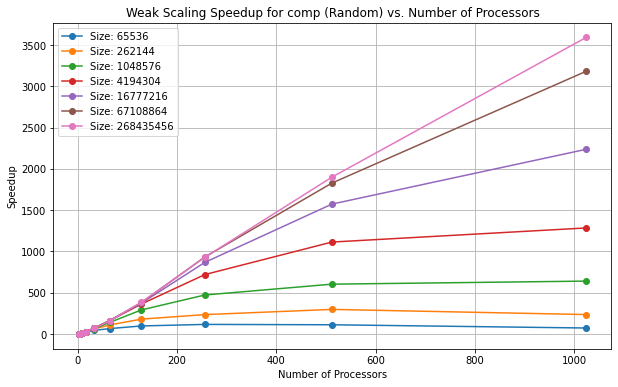

Weak Scaling Speedup for ReverseSorted (Size: 65536)
Processors: 2, Speedup: 1.0
Processors: 4, Speedup: 3.6130467571644043
Processors: 8, Speedup: 10.91569833675097
Processors: 16, Speedup: 25.72986036519871
Processors: 32, Speedup: 46.28888888888889
Processors: 64, Speedup: 75.32861635220127
Processors: 128, Speedup: 97.3760162601626
Processors: 256, Speedup: 116.56690997566909
Processors: 512, Speedup: 113.52843601895734
Processors: 1024, Speedup: 75.09247648902821
Weak Scaling Speedup for ReverseSorted (Size: 262144)
Processors: 2, Speedup: 1.0
Processors: 4, Speedup: 3.783153226934063
Processors: 8, Speedup: 11.051231182168282
Processors: 16, Speedup: 28.506321493076463
Processors: 32, Speedup: 56.995486006620524
Processors: 64, Speedup: 106.10420168067228
Processors: 128, Speedup: 192.28020304568528
Processors: 256, Speedup: 240.04562737642587
Processors: 512, Speedup: 279.7577548005909
Processors: 1024, Speedup: 228.46320868516287
Weak Scaling Speedup for ReverseSorted (Size: 10

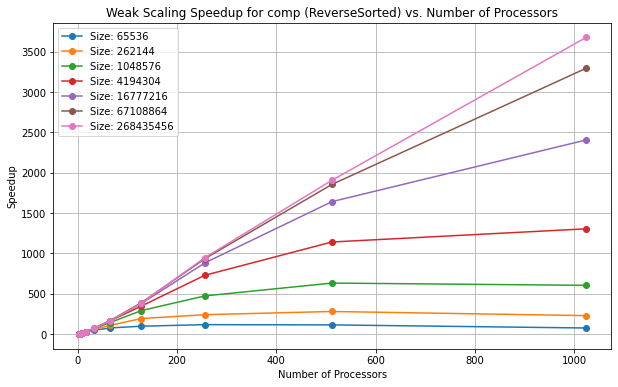

Weak Scaling Speedup for 1%_perturbed (Size: 65536)
Processors: 2, Speedup: 1.0
Processors: 4, Speedup: 3.73019782315087
Processors: 8, Speedup: 10.598645598194132
Processors: 16, Speedup: 25.094601817210048
Processors: 32, Speedup: 43.35364727608495
Processors: 64, Speedup: 73.02021772939347
Processors: 128, Speedup: 94.09218436873748
Processors: 256, Speedup: 106.7090909090909
Processors: 512, Speedup: 111.5249406175772
Processors: 1024, Speedup: 73.3625
Weak Scaling Speedup for 1%_perturbed (Size: 262144)
Processors: 2, Speedup: 1.0
Processors: 4, Speedup: 3.889761593081836
Processors: 8, Speedup: 11.108757222159285
Processors: 16, Speedup: 30.032771822358345
Processors: 32, Speedup: 62.04175893704524
Processors: 64, Speedup: 112.1933638443936
Processors: 128, Speedup: 196.70411233701103
Processors: 256, Speedup: 245.75689223057645
Processors: 512, Speedup: 290.97032640949556
Processors: 1024, Speedup: 231.26650943396228
Weak Scaling Speedup for 1%_perturbed (Size: 1048576)
Processo

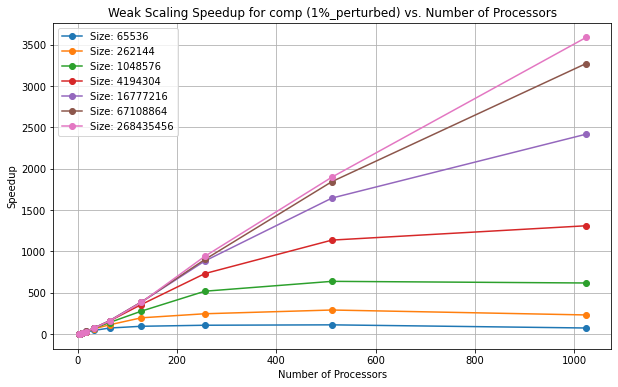

In [63]:
def plot_weak_scaling_speedup(df, phase, input_types, input_sizes):
    for input_type in input_types:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input size to plot the data for the current input type
        for input_size in input_sizes:
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_size') == input_size) &
                        (df.index.get_level_values('input_type') == input_type) &
                        (df['name'] == phase)]
            
            # Set baseline time as the Avg time/rank for the smallest processor count (num_tasks == 2)
            base_time = subset[subset.index.get_level_values('num_tasks') == 2]['Avg time/rank'].values[0]
            speedup = base_time / subset['Avg time/rank']
            
            # Print speedup values for each processor count
            print(f"Weak Scaling Speedup for {input_type} (Size: {input_size})")
            for num_tasks, speedup_value in zip(subset.index.get_level_values('num_tasks'), speedup):
                print(f"Processors: {num_tasks}, Speedup: {speedup_value}")
            
            # Plot the speedup
            plt.plot(subset.index.get_level_values('num_tasks'), speedup, 
                     label=f"Size: {input_size}", marker="o")
        
        plt.xlabel('Number of Processors')
        plt.ylabel('Speedup')
        plt.title(f"Weak Scaling Speedup for {phase} ({input_type}) vs. Number of Processors")
        plt.legend()
        plt.grid(True)
        plt.show()

# Define input types and sizes
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']
input_sizes = tk.dataframe.index.get_level_values('input_size').unique()
plot_weak_scaling_speedup(tk.dataframe, 'comp', input_types, input_sizes)


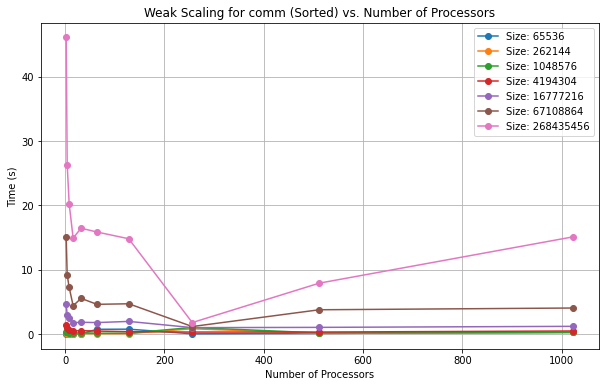

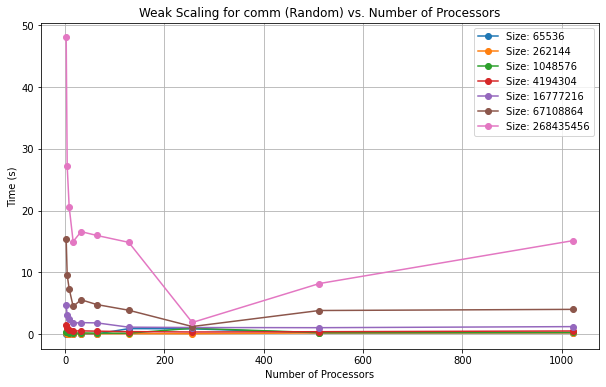

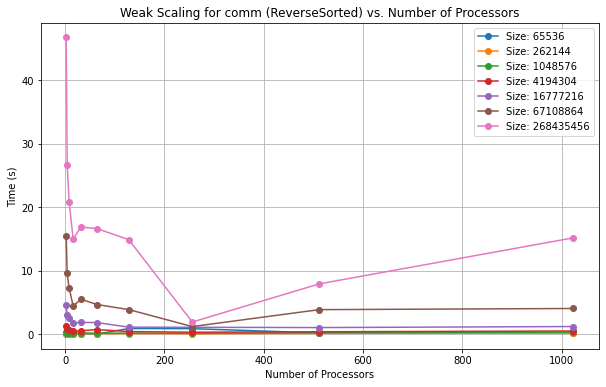

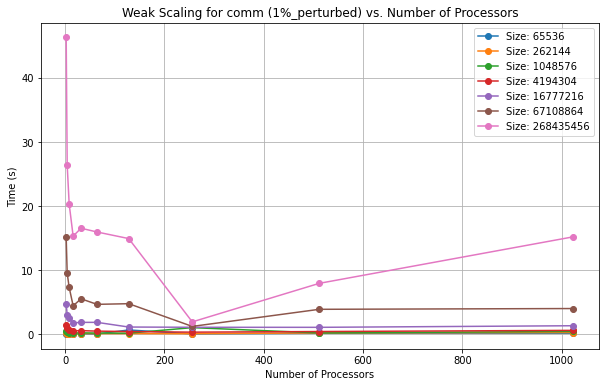

In [64]:
def plot_weak_scaling(df, phase, input_types, base_input_size):
    for input_type in input_types:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input size to plot the data for the current input type
        for input_size in df.index.get_level_values('input_size').unique():
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_type') == input_type) &
                        (df.index.get_level_values('input_size') == input_size) &
                        (df['name'] == phase)]
            
            # Calculate the time per rank for the base input size with the smallest number of processors
            base_subset = df[(df.index.get_level_values('input_type') == input_type) &
                             (df.index.get_level_values('input_size') == base_input_size) &
                             (df.index.get_level_values('num_tasks') == 2) &
                             (df['name'] == phase)]
            
            if not base_subset.empty:                
                # Calculate the relative time (weak scaling factor) by dividing by the base time per rank
                weak_scaling_factor = subset['Avg time/rank']
                
                # Plot the weak scaling factor for each input_size
                plt.plot(subset.index.get_level_values('num_tasks'), weak_scaling_factor, 
                         label=f"Size: {input_size}", marker="o")
        
        plt.xlabel('Number of Processors')
        plt.ylabel('Time (s)')
        plt.title(f"Weak Scaling for {phase} ({input_type}) vs. Number of Processors")
        plt.legend()
        plt.grid(True)
        plt.show()

# Define input types and the base input size for weak scaling
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']
base_input_size = tk.dataframe.index.get_level_values('input_size').min()  # Use the smallest input size as the base
plot_weak_scaling(tk.dataframe, 'comm', input_types, base_input_size)


In [70]:
# NEW PLOTS BELOW
import os

In [66]:
# STRONG SCALING

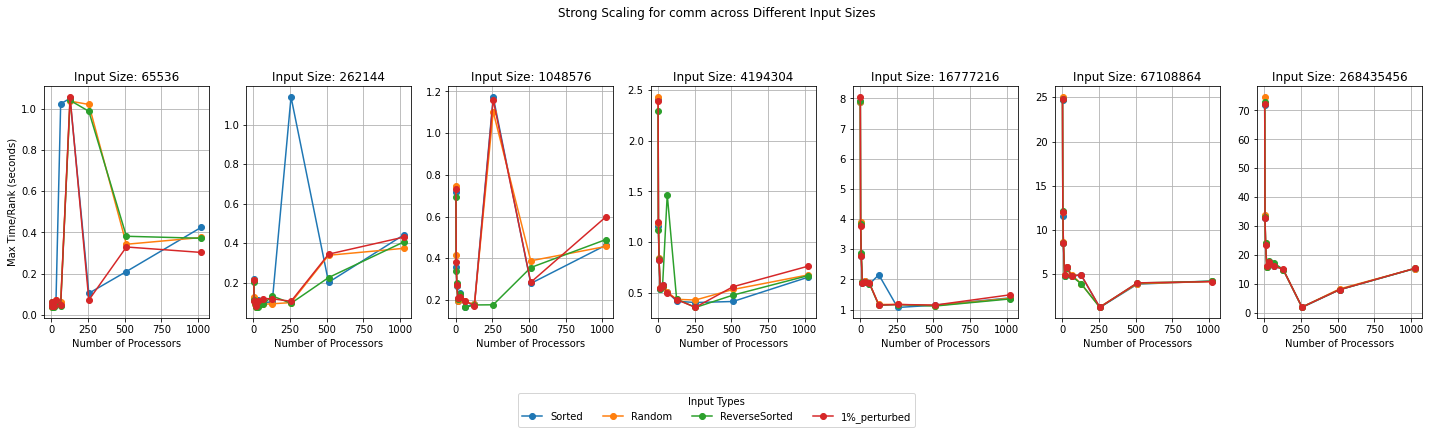

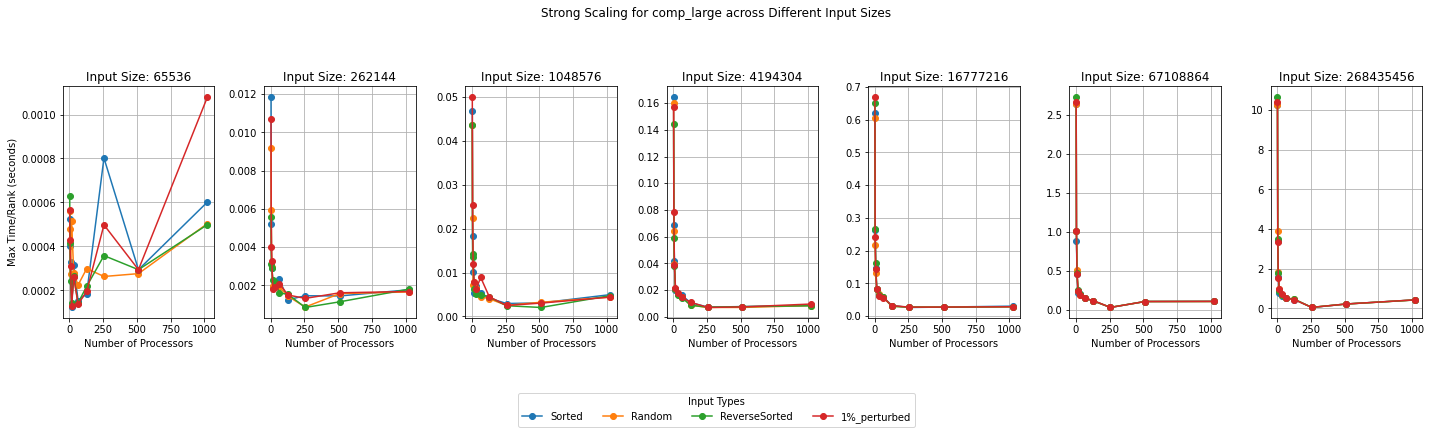

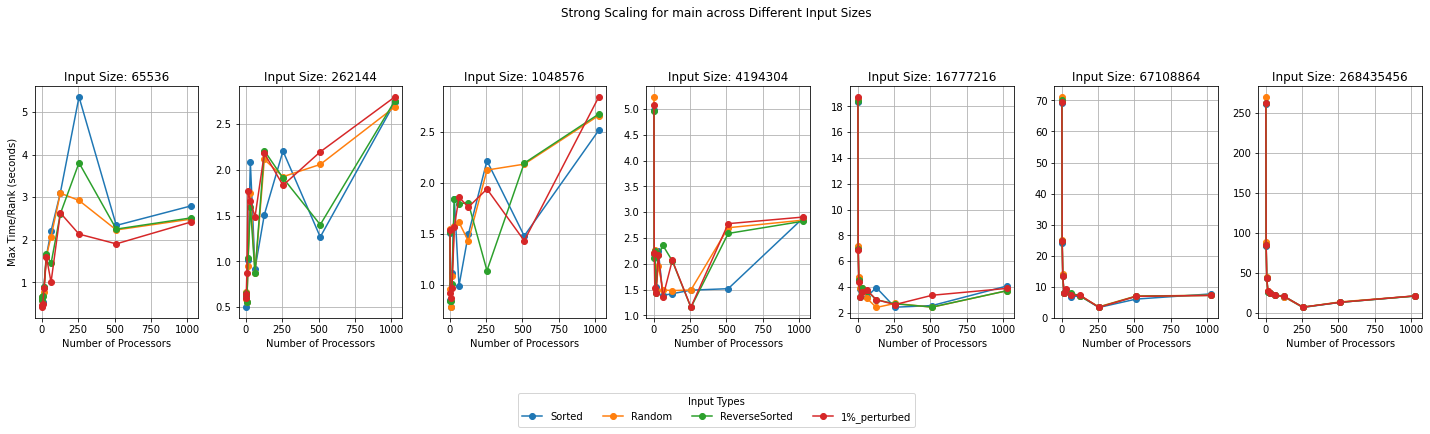

In [78]:
# Define the strong scaling plot function
# Define the directory to save the plots
save_dir = "./combined_plots"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define the strong scaling plot function with independent y-axes for each subplot
def plot_strong_scaling_combined(df, phases, input_sizes, input_types):
    for phase in phases:
        # Set up the figure with subplots, one for each input_size
        fig, axs = plt.subplots(nrows=1, ncols=len(input_sizes), figsize=(20, 5))
        fig.suptitle(f"Strong Scaling for {phase} across Different Input Sizes")
        
        # Loop through each input_size and corresponding subplot
        for i, input_size in enumerate(input_sizes):
            ax = axs[i]  # Select the subplot
            
            # Loop through each input type to plot the data for the current input_size and phase
            for input_type in input_types:
                # Filter the dataframe based on input_size, input_type, and phase
                subset = df[(df.index.get_level_values('input_size') == input_size) &
                            (df.index.get_level_values('input_type') == input_type) &
                            (df['name'] == phase)]
                
                # Plot the Max time/rank for each num_tasks (or processors)
                ax.plot(subset.index.get_level_values('num_tasks'), subset['Max time/rank'], 
                        label=f"Type: {input_type}", marker="o")
                
            ax.set_title(f"Input Size: {input_size}")
            ax.set_xlabel('Number of Processors')
            ax.grid(True)
            if i == 0:
                ax.set_ylabel('Max Time/Rank (seconds)')
        
        # Position the legend well below all subplots
        fig.legend(input_types, title="Input Types", loc="lower center", ncol=len(input_types), bbox_to_anchor=(0.5, -0.2))
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to make space for the title and legend
        
        # Save the combined plot for the current phase
        filename = f"combined_strong_scaling_{phase}.png"
        plt.savefig(os.path.join(save_dir, filename), bbox_inches="tight")
        # plt.close(fig)  # Close the figure to free memory

# Define phases, input sizes, and types
phases = ['comm', 'comp_large', 'main']
input_sizes = tk.dataframe.index.get_level_values('input_size').unique()
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']

# Call the function
plot_strong_scaling_combined(tk.dataframe, phases, input_sizes, input_types)

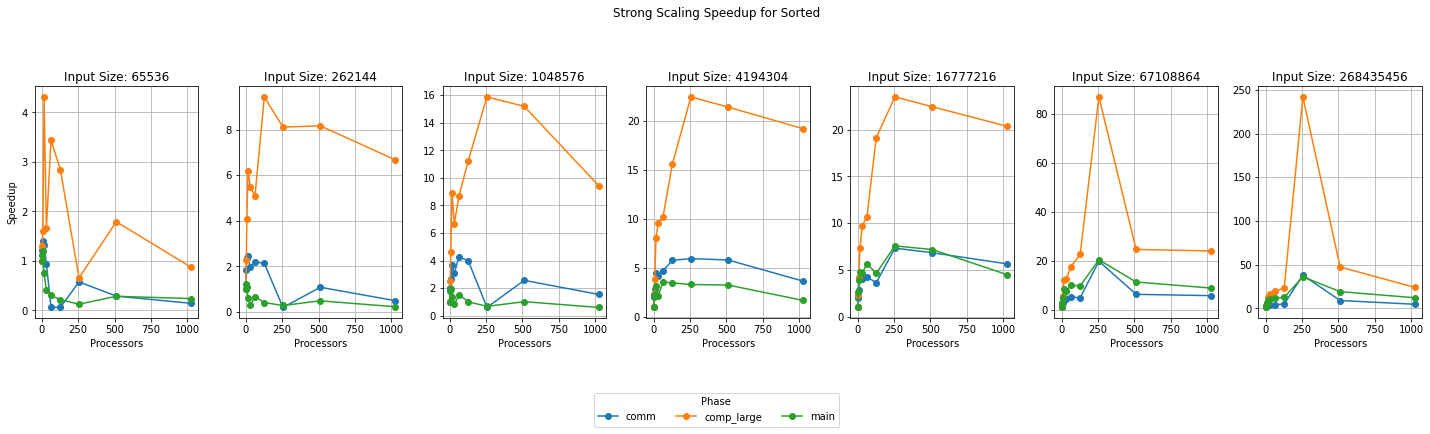

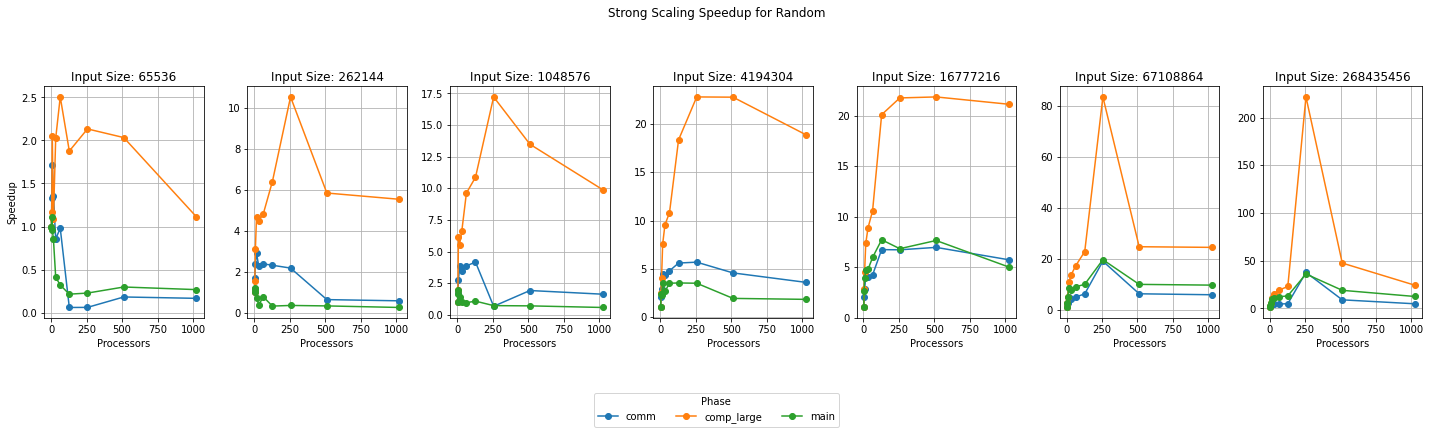

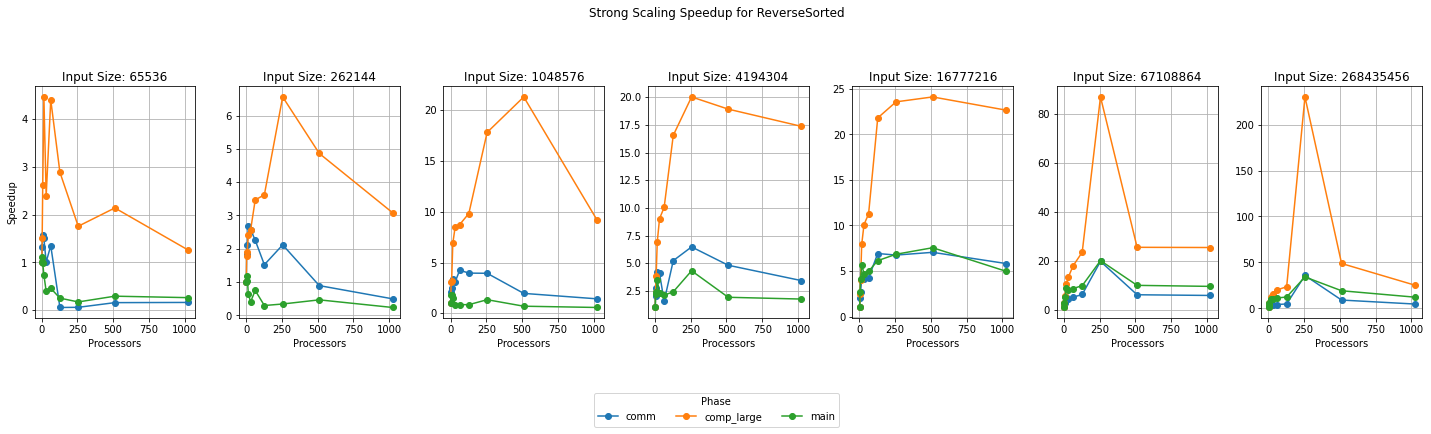

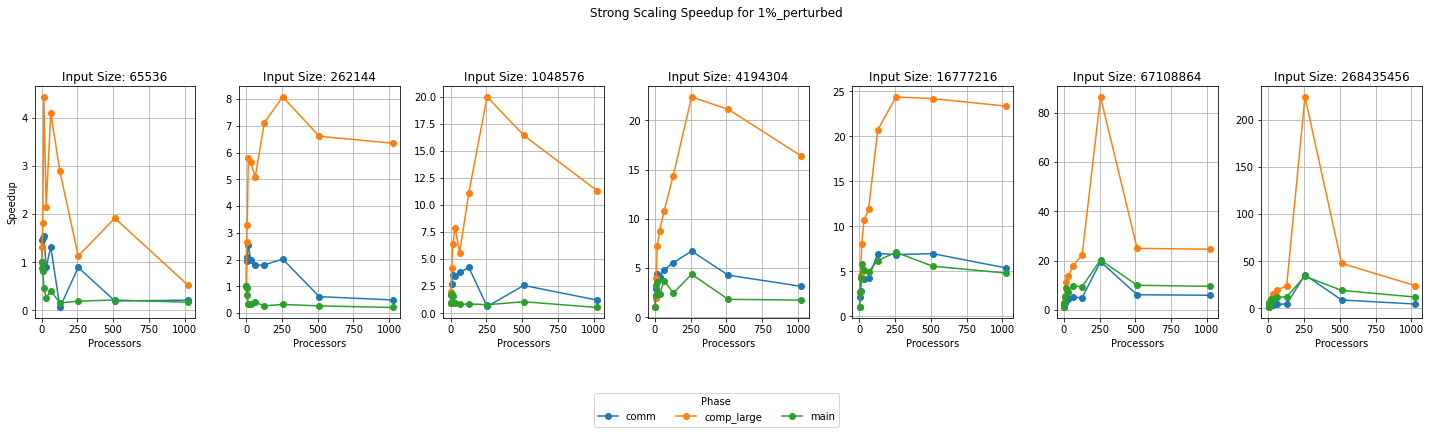

In [80]:
def plot_strong_scaling_speedup_subplots(df, phases, input_sizes, input_types):
    for input_type in input_types:
        # Set up the figure with subplots for each input_size
        fig, axs = plt.subplots(1, len(input_sizes), figsize=(20, 5))
        fig.suptitle(f"Strong Scaling Speedup for {input_type}")
        
        for i, input_size in enumerate(input_sizes):
            ax = axs[i]  # Select the subplot for the current input_size
            
            # Loop through each phase to calculate and plot speedup
            for phase in phases:
                subset = df[(df.index.get_level_values('input_size') == input_size) &
                            (df.index.get_level_values('input_type') == input_type) &
                            (df['name'] == phase)]
                
                # Calculate speedup based on the smallest processor count (2)
                base_time = subset[subset.index.get_level_values('num_tasks') == 2]['Max time/rank'].values[0]
                speedup = base_time / subset['Max time/rank']
                
                # Plot the speedup for each phase on the current subplot
                ax.plot(subset.index.get_level_values('num_tasks'), speedup, label=phase, marker="o")
            
            ax.set_title(f"Input Size: {input_size}")
            ax.set_xlabel('Processors')
            ax.grid(True)
            if i == 0:
                ax.set_ylabel('Speedup')
        
        # Position the legend at the bottom
        fig.legend(phases, title="Phase", loc="lower center", ncol=len(phases), bbox_to_anchor=(0.5, -0.2))
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout for the title and legend
        
        # Save the figure
        filename = f"strong_scaling_speedup_{input_type}.png"
        plt.savefig(os.path.join(save_dir, filename), bbox_inches="tight")
        # plt.close(fig)  # Close the figure to free memory

# Define phases, input sizes, and types
phases = ['comm', 'comp_large', 'main']
input_sizes = tk.dataframe.index.get_level_values('input_size').unique()
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']

# Call the function for strong scaling speedup plots
plot_strong_scaling_speedup_subplots(tk.dataframe, phases, input_sizes, input_types)

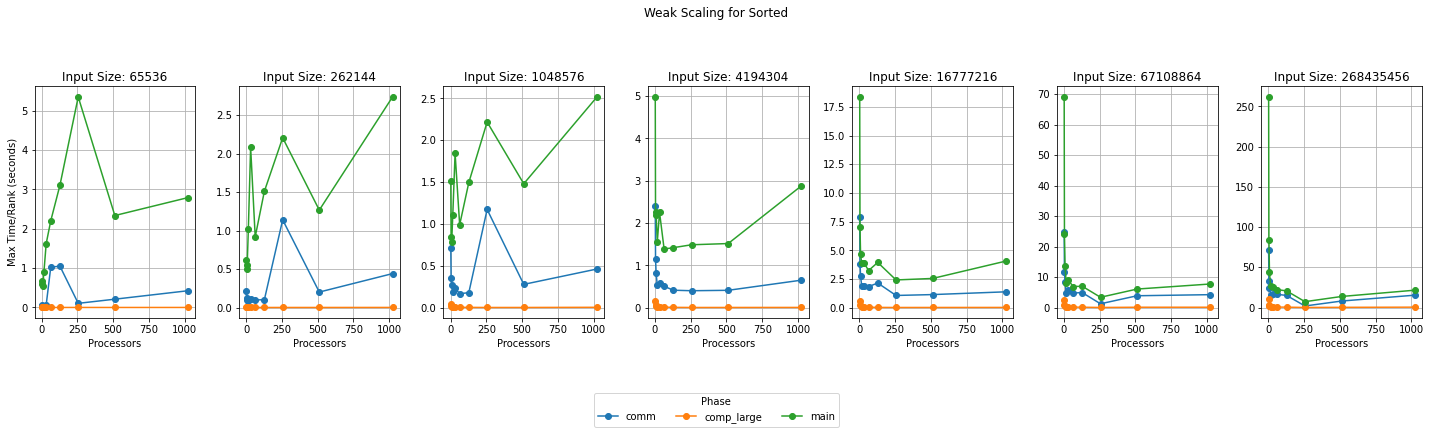

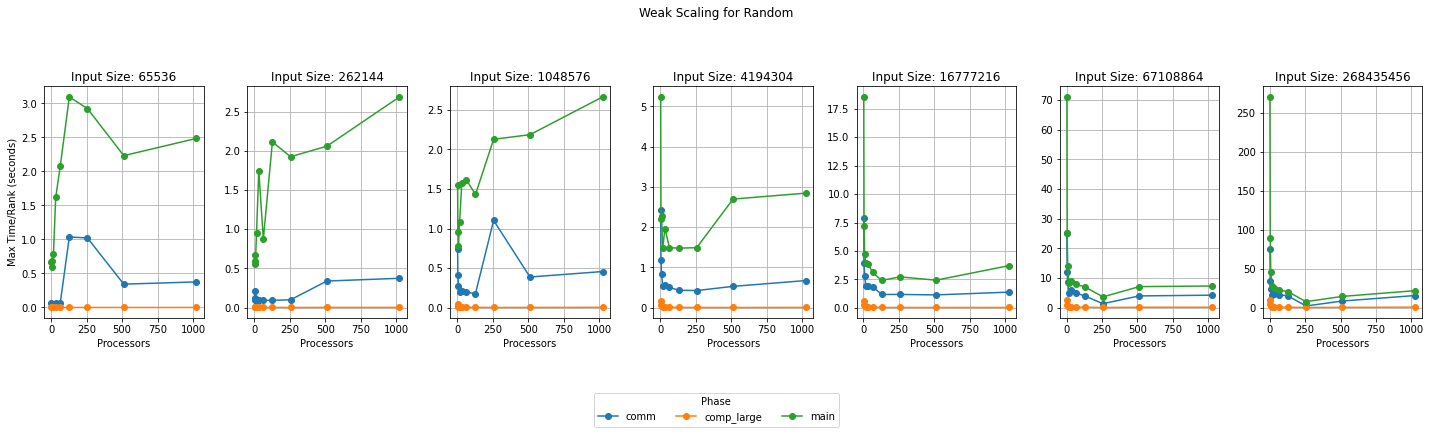

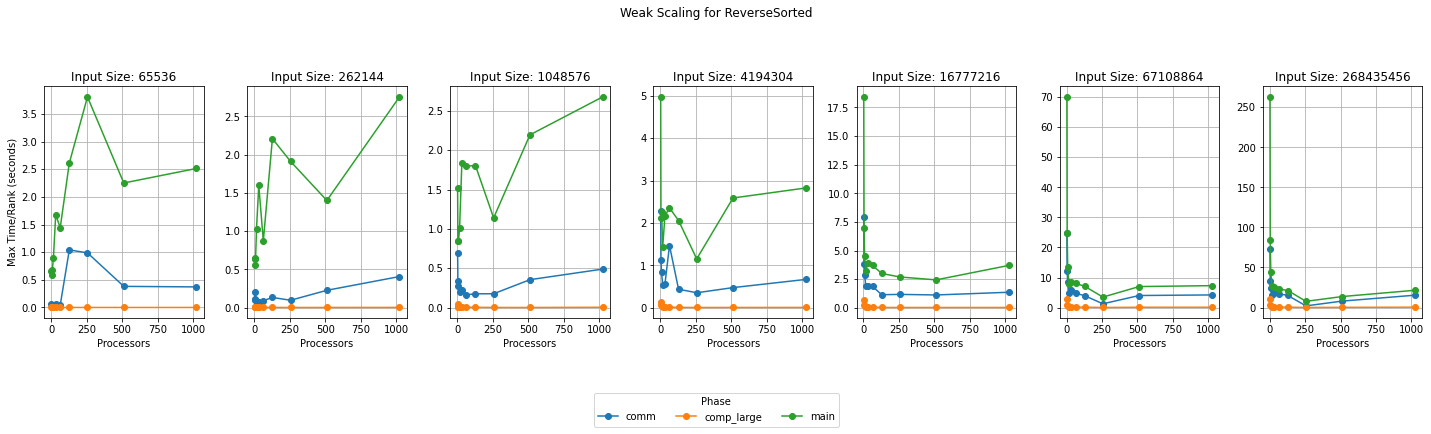

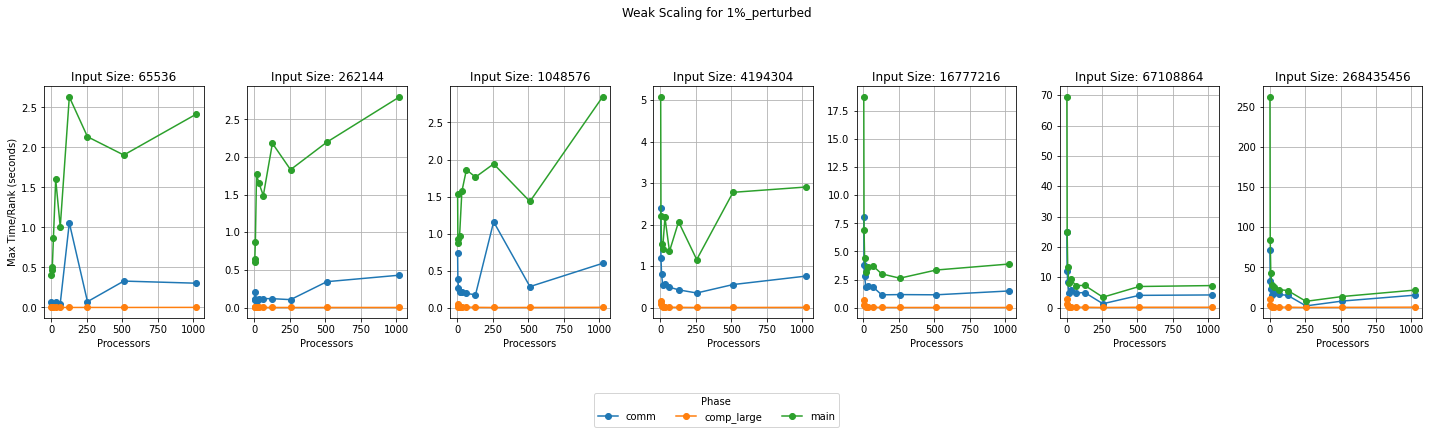

In [81]:
# Define the weak scaling plot function with subplots by input size
def plot_weak_scaling_subplots(df, phases, input_sizes, input_types):
    for input_type in input_types:
        # Set up the figure with subplots for each input_size
        fig, axs = plt.subplots(1, len(input_sizes), figsize=(20, 5))
        fig.suptitle(f"Weak Scaling for {input_type}")
        
        for i, input_size in enumerate(input_sizes):
            ax = axs[i]  # Select the subplot for the current input_size
            
            # Plot max time/rank for each phase on the current subplot
            for phase in phases:
                subset = df[(df.index.get_level_values('input_size') == input_size) &
                            (df.index.get_level_values('input_type') == input_type) &
                            (df['name'] == phase)]
                
                ax.plot(subset.index.get_level_values('num_tasks'), subset['Max time/rank'], label=phase, marker="o")
            
            ax.set_title(f"Input Size: {input_size}")
            ax.set_xlabel('Processors')
            ax.grid(True)
            if i == 0:
                ax.set_ylabel('Max Time/Rank (seconds)')
        
        # Position the legend at the bottom
        fig.legend(phases, title="Phase", loc="lower center", ncol=len(phases), bbox_to_anchor=(0.5, -0.2))
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout for the title and legend
        
        # Save the figure
        filename = f"weak_scaling_{input_type}.png"
        plt.savefig(os.path.join(save_dir, filename), bbox_inches="tight")
        # plt.close(fig)  # Close the figure to free memory

# Call the function for weak scaling plots
plot_weak_scaling_subplots(tk.dataframe, phases, input_sizes, input_types)
